In [1]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import matplotlib.image as mpimg

import warnings

import torch

from sbi.analysis import pairplot

# load and read nwb files
from pynwb import NWBHDF5IO

import sys
sys.path.append('../code')

from ephys_utils import get_time_voltage_current_currindex0, syn_current
from plot_utils import adjust_spines
from simulator import EphysModel

/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Download data

In [3]:
def download_raw_data():
    import os

    cwd = os.getcwd()

    if os.path.exists("../data/raw_data/000008/"):
        print("Data exists.")
    else:
        os.chdir("../data/raw_data")
        print("Downloading raw data using dandi. This will take a while.")
        !dandi download https://dandiarchive.org/dandiset/000008/draft
        os.chdir(cwd)


download_raw_data()

Data exists.


In [4]:
def download_data():
    import os

    cwd = os.getcwd()

    # download `full_batch.npz` to `/code/save_sims/M1_chunck`
    if os.path.exists("../code/save_sims/M1_chunks/full_batch.npz"):
        print("Data exists.")
    else:
        os.chdir("../code/save_sims/M1_chunks/")
        print("downloading `full_batch.npz` to `/code/save_sims/M1_chunck`")
        # !wget https://zenodo.org/record/7716391/files/full_batch.npz
        os.chdir(cwd)

    # download `full_batch_without_rSS.npz` to `/code/without_rss/save_sims/M1_chunk`
    if os.path.exists(
        "../code/without_rSS/save_sims/M1_chunks/full_batch_without_rSS.npz"
    ):
        print("Data exists.")
    else:
        os.chdir("../code/without_rSS/save_sims/M1_chunks/")
        print(
            "downloading `full_batch_without_rSS.npz` to `/code/without_rSS/save_sims/M1_chunks/"
        )
        !wget https://zenodo.org/record/7716391/files/full_batch_without_rSS.npz
        os.chdir(cwd)

    # download `best_1000_Euclidean_sims.npz` to `/code/save_sims/`
    if os.path.exists("../code/save_sims/best_1000_Euclidean_sims.npz"):
        print("Data exists.")
    else:
        os.chdir("../code/save_sims/M1_chunks/")
        print(
            "downloading `best_1000_Euclidean_sims.npz` to `/code/save_sims/M1_chunks/`"
        )
        !wget https://zenodo.org/record/7716391/files/best_1000_Euclidean_sims.npz
        os.chdir(cwd)


download_data()

Data exists.
Data exists.
downloading `best_1000_Euclidean_sims.npz` to `/code/save_sims/M1_chunks/`
zsh:1: command not found: wget


### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [2]:
M1_25degree = pickle.load(open("../code/pickles/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [3]:
ephys_features_w_units = np.array(
    [
        "AP threshold (mV)",
        "AP amplitude (mV)",
        "AP width (ms)",
        "AHP (mV)",
        "3rd AP threshold (mV)",
        "3rd AP amplitude (mV)",
        "3rd AP width (ms)",
        "3rd AHP (mV)",
        "AP count",
        "AP count 1st 8th",
        "AP count 1st quarter",
        "AP count 1st half",
        "AP count 2nd half",
        "AP amp adapt",
        "AP average amp adapt",
        "AP CV",
        "ISI adapt",
        "ISI CV",
        "Latency (ms)",
        "rest $V_{m}$ mean (mV)",
        "$V_{m}$ mean (mV)",
        "$V_{m}$ std (mV)",
        "$V_{m}$ skewness",
    ],
    dtype=object,
)

In [4]:
prop = pd.read_csv("../data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [5]:
annotations = pd.read_csv("../data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [6]:
dir_locs = []
for cell_name in Xo.index:
    dir_locs.append(
        np.array(M1_25degree["M1_names"])[no_low_qual][
            np.where(Xo.index == cell_name)[0][0]
        ]
    )

In [7]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [8]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

### Load simulator and simulations

In [9]:
M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=40,
    noise_factor=10,
    use_pathos=True,
    chunk_size=50000,
    save_chunks=True,
)

In [10]:
theta = np.load("../code/save_sims/M1_chunks/full_batch.npz")["theta"]
stats = np.load("../code/save_sims/M1_chunks/full_batch.npz")["stats"]
print("(# sims, # ephys features): ", stats.shape)
keeping = (~np.isnan(np.mean(stats, axis=1))) & (~np.isinf(np.mean(stats, axis=1)))
stats = stats[keeping, :]  # delete Nan simulations
print(
    "and after deleting Nan and Inf simulations: \n(# sims, # ephys features): ",
    stats.shape,
)

(# sims, # ephys features):  (15000000, 23)
and after deleting Nan and Inf simulations: 
(# sims, # ephys features):  (7155552, 23)


### Figure 2

Illustrate HH-based model's efficacy to get good 'point estimates'. By minimizing MSE in ephys feature subspace we can get simulations adequately reproducing ephys features of experimental observations.

In [11]:
cell_names = [
    "20190418_sample_8",
    "20200106_sample_1",
    "20190418_sample_2",
    "20190722_sample_1",
    "20190725_sample_3",
    "20190416_sample_7",
]

In [12]:
liquid_junction_potential = 15.4
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)

In [13]:
observations = []  # raw experimental recording
simulations = []  # best prior simulation
xos = []  # experimental ephys features
xs = []  # simulation ephys features
for cell_name in cell_names:
    data = np.array(M1_25degree["M1_names"])[no_low_qual][
        np.where(Xo.index == cell_name)[0][0]
    ]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = NWBHDF5IO(data, "r", load_namespaces=True).read()
    xo = Xo.loc[cell_name, :].iloc[:-4].values
    xos.append(xo)
    (
        time_obs,
        voltage_obs,
        current_obs,
        curr_index_0_obs,
    ) = get_time_voltage_current_currindex0(data)
    voltage_obs -= liquid_junction_potential
    I, t_on, t_off, dt, t, A_soma = syn_current(
        area=Xo.loc[cell_name, "1-comp area"], curr_level=3e-4
    )
    curr_index = np.where(current_obs == 300)[0][0]
    observation = {
        "data": voltage_obs[:20000, curr_index],
        "time": time_obs[:20000] * 1e3,
        "dt": 4 * 1e-5 * 1e3,
        "I": I,
    }
    observations.append(observation)

    ind = np.argsort(
        np.sum(
            np.square(
                (stats[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            ),
            axis=1,
        )
    )[0:1]
    x = M1_model._run_HH_model(theta[keeping, :][ind, :])
    simulations.append(x)
    xs.append(M1_model._calculate_summary_statistics(x)[0])
xos = np.array(xos)
xs = np.array(xs)

WARNING    /Users/yvesbernaerts/Documents/PhD/hh_sbi/figures/../code/ephys_utils.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  voltage[:, curr_index_0] = df.iloc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation
 [py.warnings]
WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    /Users/yvesbernaerts/Documents/PhD/hh_sbi/figures/../code/ephys_utils.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  voltage[:, curr_index_0] = df.iloc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation
 [py.warni

In [14]:
Xo_mean = Xo.values[:, feature_list].mean(axis=0)
Xo_std = Xo.values[:, feature_list].std(axis=0)

Load embedding coordinates of T-SNE based on transcriptomics. <br> (see Fig. 4 how they can be produced)

In [15]:
Z = np.load("./embedding_coordinates/tsne.npz")["coord"]

In [16]:
exps_colors = ["darkred", "salmon", "goldenrod", "lightseagreen", "purple", "darkgrey"]

In [17]:
def create_figure_2(fig):
    if fig is None:
        fig = plt.figure(figsize=(9, 3))
    else:
        fig = fig
    width, height = 0.16, 0.12

    ax_exps = [
        plt.axes([0, 0.05, width, height]),
        plt.axes([0.22, 0.66, width, height], zorder=1),
        plt.axes([0, 0.4, width, height]),
        plt.axes([0.28, 0.2, width, height], zorder=1),
        plt.axes([0.02, 0.75, width, height]),
        plt.axes([0.15, 0, width, height]),
    ]
    ax_sims = [
        plt.axes([0, 0.18, width, height]),
        plt.axes([0.22, 0.79, width, height], zorder=1),
        plt.axes([0, 0.53, width, height]),
        plt.axes([0.28, 0.33, width, height]),
        plt.axes([0.02, 0.88, width, height]),
        plt.axes([0.15, 0.13, width, height]),
    ]
    ax_embed = plt.axes([0.15, 0.3, 0.15, 0.45], zorder=0)
    ax_features = [
        [plt.axes([x, y, 0.07, 0.21]) for y in [0, 0.38, 0.76]]
        for x in [0.48, 0.61, 0.74]
    ]
    return ax_embed, ax_exps, ax_sims, ax_features

In [18]:
features_to_show = [3, 4, 8, 21, 12, 15, 17, 18, 20]

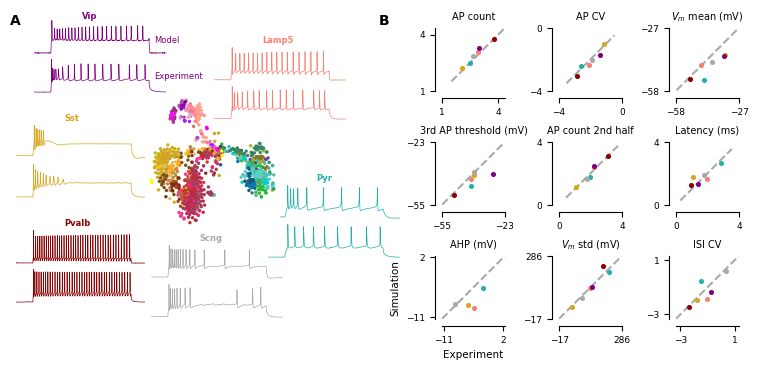

In [20]:
fig = plt.figure(figsize=(9, 3))
ax_embed, ax_exps, ax_sims, ax_features = create_figure_2(fig)
ax_embed.scatter(Z[:, 0], Z[:, 1], s=2, c=colors)
ax_embed.set_xticks([])
ax_embed.set_yticks([])
sns.despine(ax=ax_embed, left=True, bottom=True)
for i, ax in enumerate(ax_exps):
    # plot experimental observation
    ax.plot(
        observations[i]["time"],
        observations[i]["data"],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)

for i, ax in enumerate(ax_sims):
    # plot best prior simulation
    ax.plot(
        simulations[i]["time"],
        simulations[i]["data"][0, 0, :],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)


for i, ax in enumerate(np.array(ax_features).reshape(-1)):
    for j in range(6):
        ax.scatter(
            xos[j, features_to_show[i]],
            xs[j, features_to_show[i]],
            color=exps_colors[j],
            s=7,
        )
    std = xos[:, features_to_show[i]].std()
    ax.plot(
        [
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        ],
        [
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        ],
        "--",
        c="darkgrey",
        zorder=0,
    )
    ax.set_xlim(
        (
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_ylim(
        (
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_xticks(
        [
            round(xos[:, features_to_show[i]].min() - 1.1 * std),
            round(xos[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    ax.set_yticks(
        [
            round(xos[:, features_to_show[i]].min() - 1.1 * std),
            round(xos[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    if i == 0:
        ax.set_xlabel("Experiment", fontsize=7.5)
        ax.set_ylabel("Simulation", fontsize=7.5)
    ax.tick_params(which="both", labelsize=6.5)
    ax.set_title(ephys_features_w_units[features_to_show[i]], fontsize=7)
    adjust_spines(ax, ["left", "bottom"])
    sns.despine(ax=ax)

fs = 6
fig.text(0.16, 0.92, "Model", fontsize=fs, color="purple")
fig.text(0.16, 0.8, "Experiment", fontsize=fs, color="purple")
fig.text(0.06, 0.31, "Pvalb", fontsize=fs, color="darkred", fontweight="bold")
fig.text(0.28, 0.92, "Lamp5", fontsize=fs, color="salmon", fontweight="bold")
fig.text(0.06, 0.66, "Sst", fontsize=fs, color="goldenrod", fontweight="bold")
fig.text(0.08, 1, "Vip", fontsize=fs, color="purple", fontweight="bold")
fig.text(0.34, 0.46, "Pyr", fontsize=fs, color="lightseagreen", fontweight="bold")
fig.text(0.21, 0.26, "Scng", fontsize=fs, color="darkgrey", fontweight="bold")
fig.text(0, 0.98, "A", fontsize=10, color="k", fontweight="bold")
fig.text(0.41, 0.98, "B", fontsize=10, color="k", fontweight="bold")

plt.savefig("figure_2.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_2.png", bbox_inches="tight", pad_inches=0)

old version:

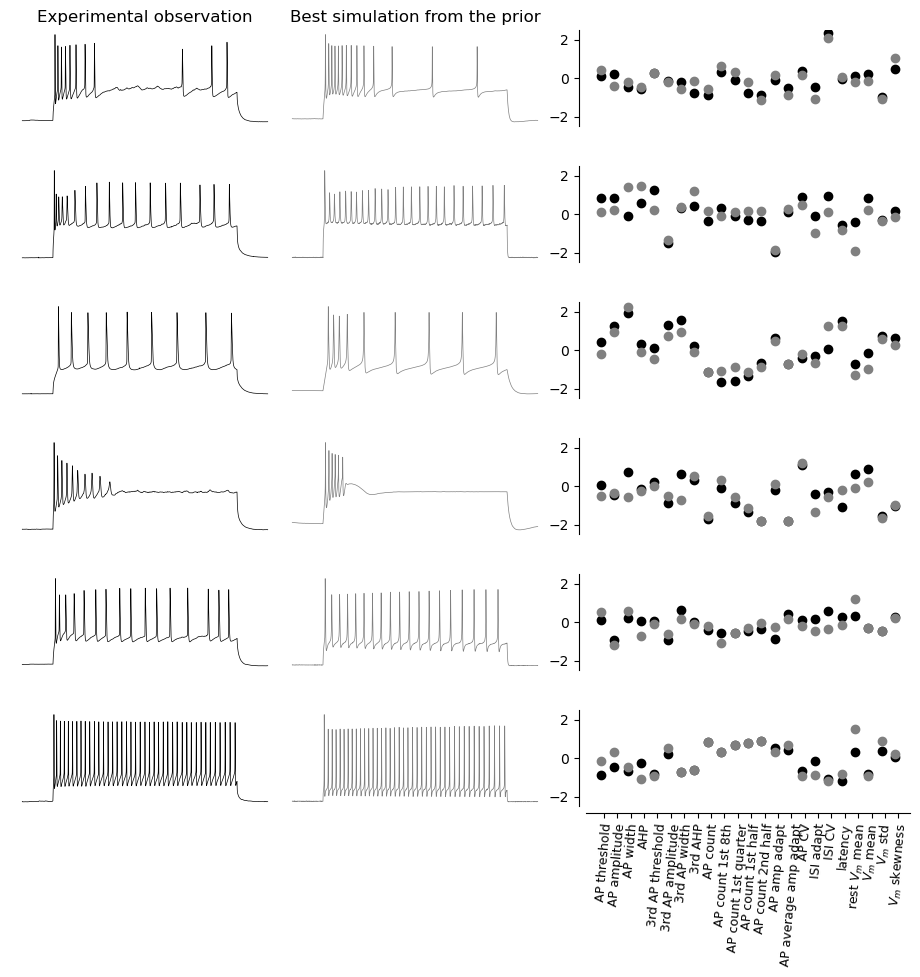

In [70]:
fig = plt.figure(figsize=(9, 8))
width = 0.3
height = 0.12
obs_axes = [plt.axes([0, y, width, height]) for y in [0, 0.17, 0.34, 0.51, 0.68, 0.85]]
sims_axes = [
    plt.axes([0.3, y, width, height]) for y in [0, 0.17, 0.34, 0.51, 0.68, 0.85]
]
feature_axes = [
    plt.axes([0.64, y, width + 0.06, height]) for y in [0, 0.17, 0.34, 0.51, 0.68, 0.85]
]
for i, ax in enumerate(obs_axes):
    # plot observation
    ax.plot(observations[i]["time"], observations[i]["data"], lw=0.5, c="k")
    if i == 5:
        ax.set_title("Experimental observation", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
for i, ax in enumerate(sims_axes):
    # plot simulation
    ax.plot(simulations[i]["time"], simulations[i]["data"][0, 0, :], lw=0.5, c="grey")
    # ax.set_xlim(obs_axes[i].get_xlim())
    # ax.set_ylim(obs_axes[i].get_ylim())
    if i == 5:
        ax.set_title("Best simulation from the prior", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
for i, ax in enumerate(feature_axes):
    # plot features
    ax.scatter(
        np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
        (xos[i] - Xo_mean) / Xo_std,
        color="k",
    )
    ax.scatter(
        np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
        (xs[i] - Xo_mean) / Xo_std,
        color="grey",
    )
    if i != 0:
        ax.set_xticks([])
        ax.set_ylim([-2.5, 2.5])
        adjust_spines(ax, ["bottom", "left"])
        sns.despine(ax=ax, bottom=True, top=True)
    else:
        adjust_spines(ax, ["bottom", "left"])
        ax.set_ylim([-2.5, 2.5])
        ax.set_xticks(
            np.linspace(1, 4 * len(ephys_features) + 2, num=len(ephys_features))
        )
        ax.set_xticklabels(ephys_features, rotation=85)
        ax.tick_params(axis="x", which="major", labelsize=9)
plt.savefig("../figures/preliminary/suppl_fig_best_sims.pdf", bbox_inches="tight", pad_inches=0)